In [1]:
R.version.string
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
BiocManager::install("DESeq2")
BiocManager::install("XML")
BiocManager::install("ggplot2")
BiocManager::install("KEGGREST")
library(KEGGREST)

[1] "R version 4.4.1 (2024-06-14)"

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.r-project.org

Bioconductor version 3.20 (BiocManager 1.30.27), R 4.4.1 (2024-06-14)

Warning message:
“package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'DESeq2'”
Old packages: 'digest', 'fansi', 'future', 'lintr', 'RcppArmadillo', 'readr',
  'S7', 'selectr', 'tinytex', 'vroom', 'xml2', 'yaml'

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.r-project.org

Bioconductor version 3.20 (BiocManager 1.30.27), R 4.4.1 (2024-06-14)

Warning message:
“package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'XML'”
Old packages: 'digest', 'fansi', 'future', 'lintr', 'RcppArmad

In [2]:
library(DESeq2) 
library(dplyr)    # ← Obligatoire pour accéder à left_join, filter...
library(ggplot2) 
library(ggrepel)
library(KEGGREST)


Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, saveRDS, setdiff,
    table, tapply, union, unique, unsplit, which.max, which.min



Attaching package: ‘S4Vectors’


The following object is masked from ‘package:utils’:

    findMatches


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Warning message:
“package ‘IRanges’ was built under R version 4.4.2”
Loading requ

In [23]:
#!/usr/bin/env Rscript

###############################################################################
# SCRIPT AUTONOME : DESeq2 + KEGG + AUREOWIKI MAPPING + MA-PLOT (TRADUCTION)
###############################################################################

suppressPackageStartupMessages({
  library(DESeq2)
  library(KEGGREST)
  library(dplyr)
  library(ggplot2)
  library(ggrepel)
})

###############################################################################
# CHEMINS (ADAPTÉS À TA STRUCTURE DE DOSSIERS)
###############################################################################

coldata_path   <- "./results/coldata/coldata.tsv"
count_matrix_path <- "./results/count_matrix/counts.txt"
aureo_map_path <- "./data/GeneSpecificInformation_NCTC8325.csv"

output_stats   <- "./results/deseq2_stats.tsv"
output_pca     <- "./results/pca_plot.png"
output_ma      <- "./results/ma_plot_translation.png"

###############################################################################
# 1. LOAD COLDATA
###############################################################################

coldata <- read.table(coldata_path, header = TRUE, sep = "\t",
                      row.names = 1, stringsAsFactors = TRUE)

coldata$Condition <- factor(coldata$Condition)
coldata$Condition <- relevel(coldata$Condition, ref = "control")

###############################################################################
# 2. LOAD COUNTS
###############################################################################

counts_raw <- read.table(count_matrix_path, header = TRUE, row.names = 1,
                         sep = "\t", stringsAsFactors = FALSE)

# Colonnes correspondantes à SRR (identiques à ton script)
counts <- as.matrix(counts_raw[, 6:11])
colnames(counts) <- gsub("\\.bam$", "", colnames(counts))
counts <- counts[, rownames(coldata)]

counts <- apply(counts, 2, as.numeric)
rownames(counts) <- rownames(counts_raw)

###############################################################################
# 3. DESEQ2
###############################################################################

dds <- DESeqDataSetFromMatrix(countData = round(counts),
                              colData = coldata,
                              design = ~ Condition)

dds <- DESeq(dds)

res <- results(dds, contrast = c("Condition", "IP", "control"), alpha = 0.05)

###############################################################################
# 4. CLEAN + EXPORT TABLE
###############################################################################

res_df <- as.data.frame(res)
res_df <- res_df[complete.cases(res_df[, c("log2FoldChange", "padj", "baseMean")]), ]
res_df$gene_id <- rownames(res_df)

###############################################################################
# 5. MAPPING AUREOWIKI (ADAPTÉ)
###############################################################################

# Fonction standard de nettoyage ID
clean_ids <- function(x) toupper(gsub("^GENE-|^gene-", "", gsub("\\s+", "", x)))

mapping <- read.table(
  "./data/GeneSpecificInformation_NCTC8325.csv",
  header = TRUE, sep = ";", stringsAsFactors = FALSE
)

clean_ids <- function(x) toupper(gsub("^GENE-|^gene-", "", gsub("\\s+", "", x)))

mapping$Locus_Tag <- clean_ids(mapping$Locus_Tag)
res_df$gene_id    <- clean_ids(res_df$gene_id)

res_df <- merge(
  res_df, mapping,
  by.x = "gene_id",
  by.y = "Locus_Tag",
  all.x = TRUE
)

###############################################################################
# 6. EXPORT STATS
###############################################################################

write.table(res_df,
            file = output_stats,
            sep = "\t", quote = FALSE, row.names = FALSE)

###############################################################################
# 7. KEGG EXTRACTION
###############################################################################

translation1 <- keggLink("sao", "sao03010")
translation2 <- keggLink("sao", "br:sao03012")
aa_metab     <- keggLink("sao", "sao00970")

clean_kegg <- function(x) toupper(gsub("sao:", "", x))

translation_tags  <- clean_kegg(translation1)
translation2_tags <- clean_kegg(translation2)
aa_tags           <- clean_kegg(aa_metab)

genes_interest <- unique(c(translation_tags, translation2_tags, aa_tags))

res_trans <- res_df %>% filter(gene_id %in% genes_interest)

###############################################################################
# 8. MA-PLOT DES GENES DE TRADUCTION
###############################################################################

res_trans$log2BaseMean <- log2(res_trans$baseMean)

png(output_ma, width = 800, height = 800, res = 150)

ggplot(res_trans,
       aes(x = log2BaseMean, y = log2FoldChange,
           color = padj < 0.05, label = gene_name)) +
  geom_hline(yintercept = 0, linetype = "dashed") +
  geom_point(size = 2, alpha = 0.7) +
  geom_text_repel(size = 4, na.rm = TRUE) +
  scale_color_manual(values = c("black", "red")) +
  theme_bw(base_size = 15) +
  labs(
    title = "MA-Plot — Gènes de traduction (KEGG)",
    x = "log2(BaseMean)",
    y = "log2 Fold Change"
  )

dev.off()

cat("\n✔ MA-PLOT enregistré dans :", output_ma, "\n")


converting counts to integer mode

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



agg_record_1005627555 
                    2


✔ MA-PLOT enregistré dans : ./results/ma_plot_translation.png 


converting counts to integer mode

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

Warning message in png(output_ma, width = 700, height = 700, res = 150, type = "cairo"):
“failed to load cairo DLL”


null device 
          1


✔ MA-PLOT (style traduction) enregistré dans : ./results/ma_plot_translation.png 


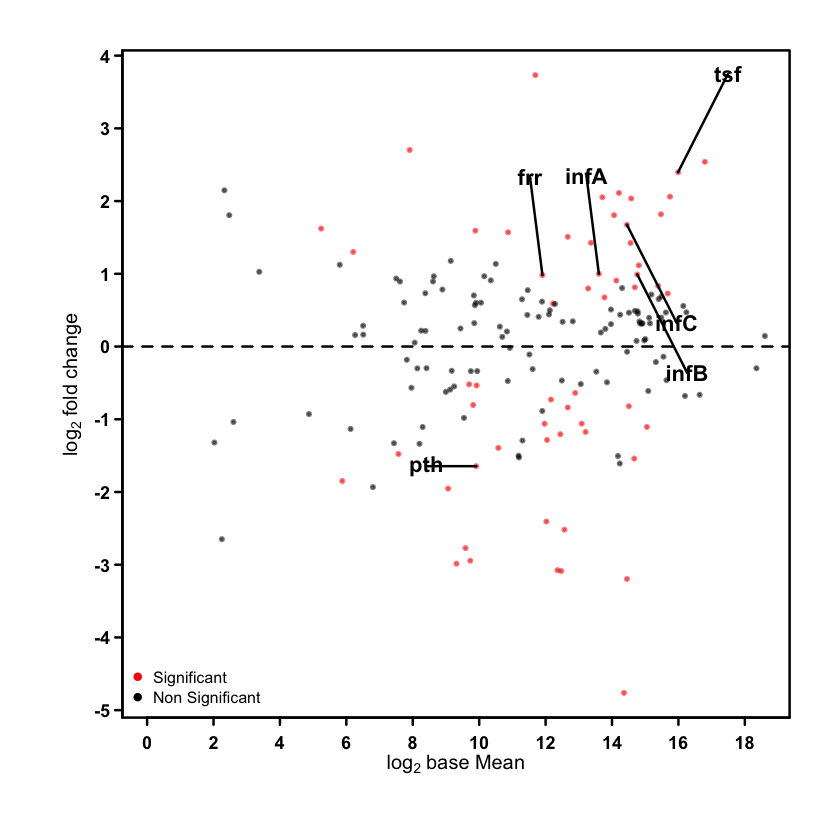

In [24]:
#!/usr/bin/env Rscript

###############################################################################
# SCRIPT AUTONOME : DESeq2 + KEGG + AUREOWIKI MAPPING + MA-PLOT (TRADUCTION)
###############################################################################

suppressPackageStartupMessages({
  library(DESeq2)
  library(KEGGREST)
  library(dplyr)
  library(ggplot2)
  library(ggrepel)
})

###############################################################################
# CHEMINS (ADAPTÉS À TA STRUCTURE DE DOSSIERS)
###############################################################################

coldata_path   <- "./results/coldata/coldata.tsv"
count_matrix_path <- "./results/count_matrix/counts.txt"
aureo_map_path <- "./data/GeneSpecificInformation_NCTC8325.csv"

output_stats   <- "./results/deseq2_stats.tsv"
output_pca     <- "./results/pca_plot.png"
output_ma      <- "./results/ma_plot_translation.png"

###############################################################################
# 1. LOAD COLDATA
###############################################################################

coldata <- read.table(coldata_path, header = TRUE, sep = "\t",
                      row.names = 1, stringsAsFactors = TRUE)

coldata$Condition <- factor(coldata$Condition)
coldata$Condition <- relevel(coldata$Condition, ref = "control")

###############################################################################
# 2. LOAD COUNTS
###############################################################################

counts_raw <- read.table(count_matrix_path, header = TRUE, row.names = 1,
                         sep = "\t", stringsAsFactors = FALSE)

# Colonnes correspondantes à SRR (identiques à ton script)
counts <- as.matrix(counts_raw[, 6:11])
colnames(counts) <- gsub("\\.bam$", "", colnames(counts))
counts <- counts[, rownames(coldata)]

counts <- apply(counts, 2, as.numeric)
rownames(counts) <- rownames(counts_raw)

###############################################################################
# 3. DESEQ2
###############################################################################

dds <- DESeqDataSetFromMatrix(countData = round(counts),
                              colData = coldata,
                              design = ~ Condition)

dds <- DESeq(dds)

res <- results(dds, contrast = c("Condition", "IP", "control"), alpha = 0.05)

###############################################################################
# 4. CLEAN + EXPORT TABLE
###############################################################################

res_df <- as.data.frame(res)
res_df <- res_df[complete.cases(res_df[, c("log2FoldChange", "padj", "baseMean")]), ]
res_df$gene_id <- rownames(res_df)

###############################################################################
# 5. MAPPING AUREOWIKI (ADAPTÉ)
###############################################################################

# Fonction standard de nettoyage ID
clean_ids <- function(x) toupper(gsub("^GENE-|^gene-", "", gsub("\\s+", "", x)))

mapping <- read.table(
  "./data/GeneSpecificInformation_NCTC8325.csv",
  header = TRUE, sep = ";", stringsAsFactors = FALSE
)

clean_ids <- function(x) toupper(gsub("^GENE-|^gene-", "", gsub("\\s+", "", x)))

mapping$Locus_Tag <- clean_ids(mapping$Locus_Tag)
res_df$gene_id    <- clean_ids(res_df$gene_id)

res_df <- merge(
  res_df, mapping,
  by.x = "gene_id",
  by.y = "Locus_Tag",
  all.x = TRUE
)

###############################################################################
# 6. EXPORT STATS
###############################################################################

write.table(res_df,
            file = output_stats,
            sep = "\t", quote = FALSE, row.names = FALSE)

###############################################################################
# 7. KEGG EXTRACTION
###############################################################################

translation1 <- keggLink("sao", "sao03010")
translation2 <- keggLink("sao", "br:sao03012")
aa_metab     <- keggLink("sao", "sao00970")

clean_kegg <- function(x) toupper(gsub("sao:", "", x))

translation_tags  <- clean_kegg(translation1)
translation2_tags <- clean_kegg(translation2)
aa_tags           <- clean_kegg(aa_metab)

genes_interest <- unique(c(translation_tags, translation2_tags, aa_tags))

res_trans <- res_df %>% filter(gene_id %in% genes_interest)

###############################################################################
# 8. MA-PLOT — STYLE IDENTIQUE AU SCRIPT DE TRADUCTION
###############################################################################

# Données
M_t <- res_trans$log2FoldChange
A_t <- log2(res_trans$baseMean)

# Couleurs (significatif vs non)
red_transp   <- "#FF000080"
black_transp <- "#00000080"
padj_cutoff  <- 0.05

point_colors_t <- ifelse(res_trans$padj < padj_cutoff, red_transp, black_transp)

# Ouverture PNG
png(output_ma, width = 700, height = 700, res = 150, type = "cairo")

# Paramètres graphiques — IDENTIQUES AU SCRIPT EXEMPLE
par(
  mar = c(5,5,2,2) + 0.1,
  font.lab = 2,
  font.axis = 2,
  cex.axis = 0.9,
  cex.lab = 1,
  col.axis = "black",
  col.lab = "black",
  mgp = c(1.5, 0.5, 0),
  lwd = 2
)

# Plot vide
plot(
  x = A_t,
  y = M_t,
  type = "n",
  xlim = c(0, max(A_t, na.rm=TRUE)),
  ylim = c(min(M_t, na.rm=TRUE), max(M_t, na.rm=TRUE)),
  xlab = expression(log[2]~"base Mean"),
  ylab = expression(log[2]~"fold change"),
  xaxt = "n",
  yaxt = "n",
  bty = "o"
)

# Ligne pointillée
abline(h = 0, col = "black", lty = 2)

# Axes
axis(side = 1, at = seq(0, 20, by = 2), lwd = 2, lwd.ticks = 2, tcl = -0.3)
axis(side = 2, at = seq(-6, 5, by = 1), lwd = 2, lwd.ticks = 2, tcl = -0.3, las = 1)

# Points
points(
  x = A_t,
  y = M_t,
  col = point_colors_t,
  pch = 20,
  cex = 0.6
)

###############################################################################
# ANNOTATIONS — IDENTIQUES À L’EXEMPLE (pth, frr, infA, tsf, infC, infB)
###############################################################################

gene_positions <- list(
  pth   = list(offset_x = -2,   offset_y = 0),
  frr   = list(offset_x = -0.5, offset_y = 1.8),
  infA  = list(offset_x = -0.5, offset_y = 1.8),
  tsf   = list(offset_x = 2,    offset_y = 1.8),
  infC  = list(offset_x = 2,    offset_y = -1.8),
  infB  = list(offset_x = 2,    offset_y = -1.8)
)

for (g in names(gene_positions)) {
  if (g %in% res_trans$gene_name) {
    x0 <- log2(res_trans$baseMean[res_trans$gene_name == g])
    y0 <- res_trans$log2FoldChange[res_trans$gene_name == g]

    x1 <- x0 + (gene_positions[[g]]$offset_x * 0.75)
    y1 <- y0 + (gene_positions[[g]]$offset_y * 0.75)

    arrows(x0, y0, x1, y1, length = 0, col = "black", lwd = 2)

    text(x1, y1, labels = g, cex = 1.1, font = 2)
  }
}

# Légende identique
legend("bottomleft",
       legend = c("Significant", "Non Significant"),
       col = c("red", "black"),
       pch = 20,
       pt.cex = 1,
       cex = 0.8,
       bty = "n")

dev.off()

cat("\n✔ MA-PLOT (style traduction) enregistré dans :", output_ma, "\n")



converting counts to integer mode

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

Warning message in png(output_ma, width = 1500, height = 1500, res = 200, type = "cairo"):
“failed to load cairo DLL”


null device 
          1

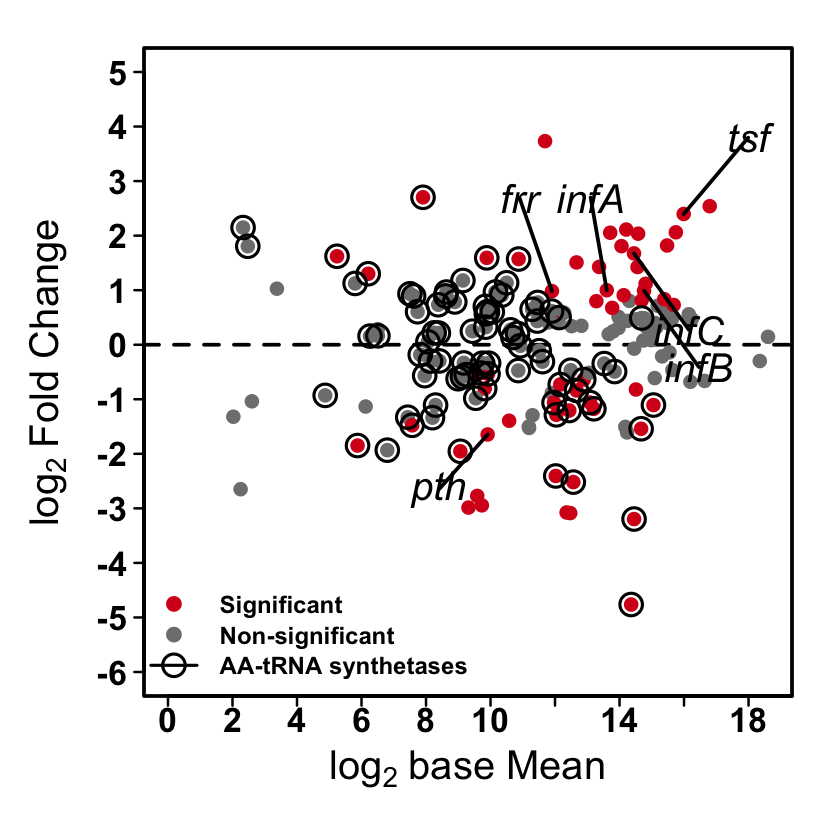

In [ ]:
#!/usr/bin/env Rscript

###############################################################################
# SCRIPT AUTONOME : DESeq2 + KEGG + AUREOWIKI MAPPING + MA-PLOT (TRADUCTION)
###############################################################################

suppressPackageStartupMessages({
  library(DESeq2)
  library(KEGGREST)
  library(dplyr)
  library(ggplot2)
  library(ggrepel)
})

###############################################################################
# CHEMINS (ADAPTÉS À TA STRUCTURE DE DOSSIERS)
###############################################################################

coldata_path   <- "./results/coldata/coldata.tsv"
count_matrix_path <- "./results/count_matrix/counts.txt"
aureo_map_path <- "./data/GeneSpecificInformation_NCTC8325.csv"

output_stats   <- "./results/deseq2_stats.tsv"
output_pca     <- "./results/pca_plot.png"
output_ma      <- "./results/ma_plot_translation.png"

###############################################################################
# 1. LOAD COLDATA
###############################################################################

coldata <- read.table(coldata_path, header = TRUE, sep = "\t",
                      row.names = 1, stringsAsFactors = TRUE)

coldata$Condition <- factor(coldata$Condition)
coldata$Condition <- relevel(coldata$Condition, ref = "control")

###############################################################################
# 2. LOAD COUNTS
###############################################################################

counts_raw <- read.table(count_matrix_path, header = TRUE, row.names = 1,
                         sep = "\t", stringsAsFactors = FALSE)

# Colonnes correspondantes à SRR (identiques à ton script)
counts <- as.matrix(counts_raw[, 6:11])
colnames(counts) <- gsub("\\.bam$", "", colnames(counts))
counts <- counts[, rownames(coldata)]

counts <- apply(counts, 2, as.numeric)
rownames(counts) <- rownames(counts_raw)

###############################################################################
# 3. DESEQ2
###############################################################################

dds <- DESeqDataSetFromMatrix(countData = round(counts),
                              colData = coldata,
                              design = ~ Condition)

dds <- DESeq(dds)

res <- results(dds, contrast = c("Condition", "IP", "control"), alpha = 0.05)

###############################################################################
# 4. CLEAN + EXPORT TABLE
###############################################################################

res_df <- as.data.frame(res)
res_df <- res_df[complete.cases(res_df[, c("log2FoldChange", "padj", "baseMean")]), ]
res_df$gene_id <- rownames(res_df)

###############################################################################
# 5. MAPPING AUREOWIKI (ADAPTÉ)
###############################################################################

# Fonction standard de nettoyage ID
clean_ids <- function(x) toupper(gsub("^GENE-|^gene-", "", gsub("\\s+", "", x)))

mapping <- read.table(
  "./data/GeneSpecificInformation_NCTC8325.csv",
  header = TRUE, sep = ";", stringsAsFactors = FALSE
)

clean_ids <- function(x) toupper(gsub("^GENE-|^gene-", "", gsub("\\s+", "", x)))

mapping$Locus_Tag <- clean_ids(mapping$Locus_Tag)
res_df$gene_id    <- clean_ids(res_df$gene_id)

res_df <- merge(
  res_df, mapping,
  by.x = "gene_id",
  by.y = "Locus_Tag",
  all.x = TRUE
)

###############################################################################
# 6. EXPORT STATS
###############################################################################

write.table(res_df,
            file = output_stats,
            sep = "\t", quote = FALSE, row.names = FALSE)

###############################################################################
# 7. KEGG EXTRACTION
###############################################################################

translation1 <- keggLink("sao", "sao03010")
translation2 <- keggLink("sao", "br:sao03012")
aa_metab     <- keggLink("sao", "sao00970")

clean_kegg <- function(x) toupper(gsub("sao:", "", x))

translation_tags  <- clean_kegg(translation1)
translation2_tags <- clean_kegg(translation2)
aa_tags           <- clean_kegg(aa_metab)

genes_interest <- unique(c(translation_tags, translation2_tags, aa_tags))

res_trans <- res_df %>% filter(gene_id %in% genes_interest)

###############################################################################
# 8. MA-PLOT — STYLE IDENTIQUE À L’EXEMPLE FOURNI
###############################################################################

# Données
M_t <- res_trans$log2FoldChange
A_t <- log2(res_trans$baseMean)

# Seuil de signifiance
padj_cutoff <- 0.05

# Couleurs "naturelles" comme sur la figure :
# - Significatif = rouge vif
# - Non-significatif = gris foncé
point_colors_t <- ifelse(res_trans$padj < padj_cutoff, "#D7191C", "#7F7F7F")

# OUVERTURE PNG — large pour un rendu publication
png(output_ma, width = 1500, height = 1500, res = 200, type = "cairo")

# Paramètres graphiques
par(
  mar = c(6,6,2,2),
  font = 2,
  font.lab = 2,
  font.axis = 2,
  cex.lab = 2,
  cex.axis = 1.7,
  lwd = 3,             # épaisseur des axes (très important)
  mgp = c(3, 0.7, 0)
)

# Plot vide (avec axes personnalisés)
plot(
  A_t, M_t,
  type = "n",
  xlab = expression(log[2]~"base Mean"),
  ylab = expression(log[2]~"Fold Change"),
  xlim = c(0, max(A_t, na.rm=TRUE)),
  ylim = c(-6,5),
  xaxt = "n",
  yaxt = "n",
  bty = "o"
)

# Axes épais
axis(1, at = seq(0,20,2), lwd = 3, lwd.ticks = 2, tcl = -0.4)
axis(2, at = seq(-6,5,1), las = 1, lwd = 3, lwd.ticks = 2, tcl = -0.4)

# Ligne pointillée horizontale
abline(h = 0, lty = 2, lwd = 3)

# --- POINTS
points(
  A_t, M_t,
  col = point_colors_t,
  pch = 20,
  cex = 1.8
)

# --- Cercles noirs pour AA-tRNA synthetases
aa_mask <- res_trans$gene_id %in% aa_tags

points(
  A_t[aa_mask],
  M_t[aa_mask],
  pch = 1,             # cercle vide
  cex = 2.5,           # taille
  lwd = 2.5,           # épais
  col = "black"
)

###############################################################################
# ANNOTATIONS 
###############################################################################

genes_to_label <- c("pth","frr","infA","tsf","infC","infB")

for (g in genes_to_label) {
  if (g %in% res_trans$gene_name) {
    i <- which(res_trans$gene_name == g)[1]
    x0 <- A_t[i]
    y0 <- M_t[i]

    # Offsets par défaut (ajustables)
    offsets <- list(
      pth  = c(-1.5,-1),
      frr  = c(-1,1.7),
      infA = c(-0.5,1.7),
      tsf  = c(2,1.4),
      infC = c(1.7,-1.4),
      infB = c(1.7,-1.4)
    )

    dx <- offsets[[g]][1]
    dy <- offsets[[g]][2]

    # Flèche
    arrows(x0, y0, x0+dx, y0+dy, length = 0, lwd = 3)

    # Texte
    text(x0+dx, y0+dy, labels = g, cex = 2, font = 3)
  }
}

# Légende identique
legend(
  "bottomleft",
  legend = c("Significant","Non-significant","AA-tRNA synthetases"),
  col = c("#D7191C","#7F7F7F","black"),
  pch = c(20,20,1),
  pt.cex = c(2,2,2.5),
  lwd = c(NA,NA,2.5),
  bty = "n",
  cex = 1.2
)

dev.off()
